# Imports

In [21]:
import cv2
import csv
import os
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import Input, UpSampling2D, MaxPooling2D
from keras.models import Model
from keras.models import model_from_json
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from sklearn.cluster import KMeans
import pylab
import librosa
import librosa.display
import matplotlib
%matplotlib inline

#### Set Root Path to Your Directory

In [10]:
ROOT_PATH = "/Users/ridakhan/Desktop/PR3/"
DATA_PATH = ROOT_PATH + "dataset/"
MEL_PATH = ROOT_PATH + 'audioimages/melspec/'
WEIGHTS_PATH = ROOT_PATH + "Models/"
RESULTS_PATH = ROOT_PATH + "Results/"

#### Function to calculate mean squared error for evaluation purposes. 

In [4]:
def mse(imageA, imageB):

    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])

    return err

# Dataset

#### Creating the mel spectrograms and saving them in directory

Song_path: path to the audio files
    
Save_path: path to save the spectrograms

In [6]:
def create_mel_spec(song_path, save_path):
    for songname in os.listdir(song_path):

        audio_path= DATA_PATH + songname #+ '.wav' #location
        sig, fs = librosa.load(audio_path)   
        pylab.axis('off') # no axis
        pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[]) # Remove the white edge
        S = librosa.feature.melspectrogram(y=sig, sr=fs)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        pylab.axis('off')
        pylab.margins(0,0)
        pylab.gca().xaxis.set_major_locator(plt.NullLocator())
        pylab.gca().yaxis.set_major_locator(plt.NullLocator())
        name = songname.split(".")[0]
        pylab.savefig(save_path + name + ".png", bbox_inches=None, pad_inches=0, aspect = 'auto')
        pylab.close()
    print("Saved all images at ", save_path)

In [ ]:
create_mel_spec(DATA_PATH, MEL_PATH)

#### Loading the images into an array

In [7]:
def load_imgs(path):
    dataset = []
    for i in range(1, 672):
        imgname = str(i) + ".png"
        img = cv2.imread(path + imgname, 1)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            dataset.append(img)
    dataset = np.array(dataset)
    return dataset

In [11]:
data_set = load_imgs(MEL_PATH)
print(data_set.shape)

(671, 288, 432, 3)


Sample Frame

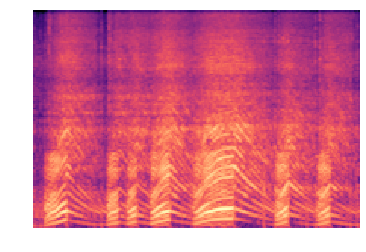

In [37]:
plt.imshow(data_set[0])
plt.axis("off")
plt.show()

#### Splitting the images into blocks of size (144, 144, 3) to use as input to the model

In [13]:
# Define the window size
block_size = 144

w, h = data_set[0].shape[0], data_set[0].shape[1]
block_data_set = []

for img in data_set:
    for r in range(0, w, block_size): # 144
        for c in range(0, h, block_size): # 288
            block_data_set.append(img[r:r+block_size,c:c+block_size]) 

block_data_set = np.array(block_data_set)
print(block_data_set.shape)

(4026, 144, 144, 3)


# Training

In [23]:
MODEL_INDEX = 60
modelname = "PR3_" + str(MODEL_INDEX)
print(modelname)

input_img = Input(shape=(144, 144, 3))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

x = Conv2D(16, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='relu', padding='same')(x)

extraction_model = Model(input_img, decoded)
extraction_model.compile(optimizer='adam', loss='mse')

extraction_model.summary()

PR3_60
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 144, 144, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 144, 144, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 36, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 16)        0         
___

In [11]:
model_json = extraction_model.to_json()

with open(ROOT_PATH + 'Models/' + modelname + '.json', "w") as json_file:
    json_file.write(model_json)

earlystop = EarlyStopping(monitor='loss', 
                          min_delta=0.09, 
                          patience=20, 
                          verbose=2, 
                          mode='auto', 
                          baseline=None, 
                          restore_best_weights=True)  

checkpointer = ModelCheckpoint(filepath = ROOT_PATH + 'Models/' + modelname + '.hdf5', 
                               monitor='loss',
                               save_best_only=True)

callbacks_list = [earlystop, checkpointer]


extraction_model.fit(block_data_set, block_data_set,
                     batch_size=4, 
                     epochs=500, 
                     callbacks=callbacks_list)

PR3_60
Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 144, 144, 3)]     0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 144, 144, 32)      896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 72, 72, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 36, 36, 16)        4624      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 18, 18, 16)

# Testing

#### Loading weights into the autoencoder and encoder 

In [25]:
encoder = Model(input_img, encoded)

modelname = "PR3_" + str(MODEL_INDEX)
WEIGHTS_PATH = ROOT_PATH + "Models/"
print(modelname)

# load weights into model
extraction_model.load_weights(filepath = WEIGHTS_PATH + modelname + '.hdf5')
print("Loaded " + modelname +" from disk")

for i in range(0, len(encoder.layers)):

    extracted_weights = extraction_model.layers[i].get_weights()
    encoder.layers[i].set_weights(extracted_weights)

PR3_60
Loaded PR3_60 from disk


#### Predicting using the autoencoder (reconstructing the spectrograms)

In [26]:
block_pred = extraction_model.predict(block_data_set)
print(block_pred.shape)

(4026, 144, 144, 3)


Putting the blocks back together to form the images and calculating the mean Mean Squared Error for the autoencoder

In [27]:
width, height = 288, 432
bm = 144
N_mblocks = int((width*height)/(bm*bm))

full_pred = []
f = block_pred.reshape(671, N_mblocks, bm*bm, 3)
for n in f:
    result = np.zeros((width, height,3))
    i = 0
    for y in range(0, result.shape[0], bm):
        for x in range(0, result.shape[1], bm):
            res = n[i].reshape(bm,bm,3)
            result[y:y + bm, x:x + bm] = res
            i = i + 1
    full_pred.append(result)

full_pred = np.array(full_pred)
print(full_pred.shape)

total_mse = []
for img1, img2 in zip(data_set, full_pred):
    total_mse.append(mse(img1, img2))

print("MSE ", round(np.mean(total_mse), 2))

(671, 288, 432, 3)
MSE  1102.11


#### Visualisations of Reconstructed Frames

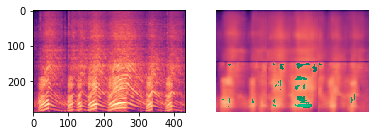

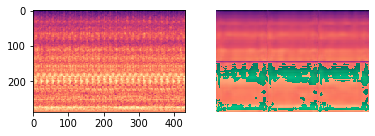

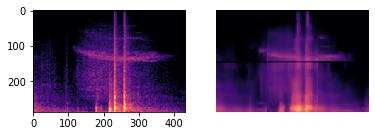

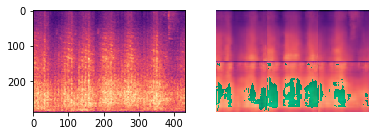

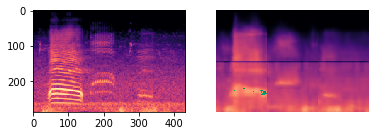

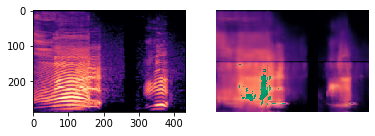

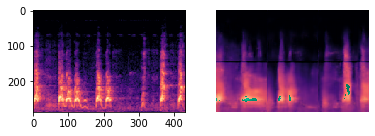

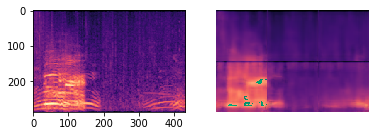

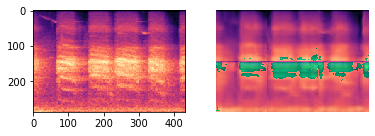

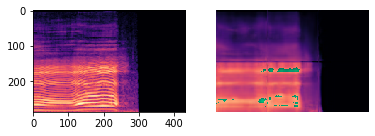

In [28]:
for i in range(0, 10):
    
    img1 = data_set[i]
    img2 = full_pred[i]
    f, axarr = plt.subplots(1,2) 

    axarr[0].imshow(img1)
    plt.axis("off")

    axarr[1].imshow((img2).astype(np.uint8))

    plt.axis("off")
    plt.show()

#### Predicting using the encoder (feature extraction)

Encoder Prediction using the blocks data. The output is the compressed version of the original data for compression ratio = 0.0013

In [29]:
encoder_block_pred = encoder.predict(block_data_set)
print(encoder_block_pred.shape)

(4026, 9, 9, 1)


#### Visualisations of Features

(671, 18, 27, 1)


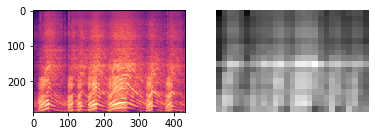

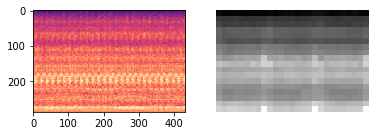

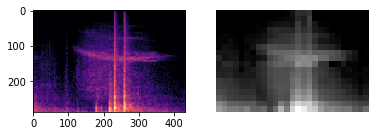

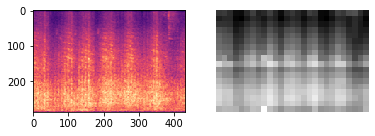

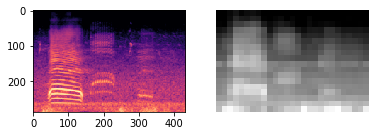

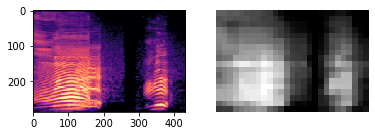

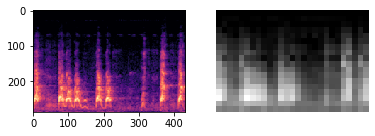

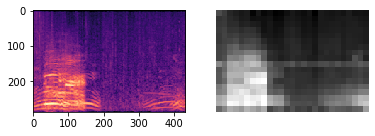

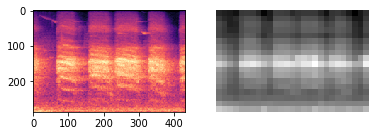

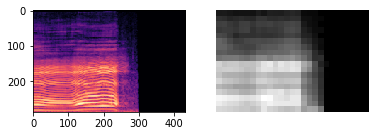

In [30]:
width, height = 18, 27
bm = 9
N_mblocks = int((width*height)/(bm*bm))

encoder_full_pred = []
f = encoder_block_pred.reshape(671, N_mblocks, bm*bm, 1)
for n in f:
    result = np.zeros((width, height,1))
    i = 0
    for y in range(0, result.shape[0], bm):
        for x in range(0, result.shape[1], bm):
            res = n[i].reshape(bm,bm,1)
            result[y:y + bm, x:x + bm] = res
            i = i + 1
    encoder_full_pred.append(result)

encoder_full_pred = np.array(encoder_full_pred)
print(encoder_full_pred.shape)

channels = encoder_full_pred.shape[3]
w, h = encoder_full_pred.shape[1], encoder_full_pred.shape[2]

for i in range(0, 10):
    
    img1 = data_set[i]
    img2 = encoder_full_pred[i]

    sample = []
    for i in range(0, channels):

        sample1 = img2[0:w, 0:h, i:i+1]
        sample1 = sample1.reshape(w, h)
        sample.append(sample1)

    f1, axarr1 = plt.subplots(1, channels + 1) 

    axarr1[0].imshow(img1, cmap='gray')

    for i in range(1, channels+1):
        axarr1[i].imshow(sample[i-1], cmap='gray')

    plt.axis("off")
    plt.show()


## K-Means Clustering

In [32]:
print(encoder_full_pred.shape)

vectshape = encoder_full_pred.shape[1] * encoder_full_pred.shape[2] * encoder_full_pred.shape[3]
flat = encoder_full_pred.reshape(671, vectshape)
print(flat.shape)

flat = flat.astype('float32') 
flat = flat/255.0

km1 = KMeans(n_clusters = 20)
km1.fit(flat)

pred1 = km1.labels_
pred1 = pred1 + 1

(671, 18, 27, 1)
(671, 486)


Storing the results into a text file

In [33]:
RESULTS_PATH = ROOT_PATH + "Results/"
filename = RESULTS_PATH + modelname + "_FinalResults.txt"

with open(filename, 'w', newline='') as w1:

    writer = csv.writer(w1, delimiter=' ')

    for p in pred1:
        writer.writerow([p])

print("Results stored at ", filename)

Results stored at  /Users/ridakhan/Desktop/PR3/Results/PR3_60_FinalResults.txt
